# Task 5

Load and configure the needed modules.

In [56]:
import numpy as np
import random
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import SGD
from keras.utils import np_utils
from scipy.ndimage.interpolation import rotate
from task5_utils import *

%load_ext autoreload
%autoreload 2

# inline plots
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Prepare data and model parameters.

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

num_validation = int(X_train.shape[0] * 0.1)
num_training = X_train.shape[0] - num_validation

mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

print 'X_train: ', X_train.shape
print 'y_train: ', y_train.shape
print 'X_val: ', X_val.shape
print 'y_val: ', y_val.shape
print 'X_test: ', X_test.shape
print 'y_test: ', y_test.shape

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

checkpoint_file = 'rot_90.hdf5'
nb_classes = 4
batch_size = 128
nb_epoch = 15

X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols).astype('float32') / 255
X_val = X_val.reshape(X_val.shape[0], 1, img_rows, img_cols).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols).astype('float32') / 255

X_train:  (54000L, 28L, 28L)
y_train:  (54000L,)
X_val:  (6000L, 28L, 28L)
y_val:  (6000L,)
X_test:  (10000L, 28L, 28L)
y_test:  (10000L,)


In [3]:
%%time
num_rotated_per_image = 1
angles = range(0, 360, 360 / nb_classes)
X_train, y_train_angle = rotate_images(X_train, num_rotated_per_image, angles)
X_val, y_val_angle = rotate_images(X_val, num_rotated_per_image, angles)
X_test, y_test_angle = rotate_images(X_test, num_rotated_per_image, angles)

y_train_angle_binary = np_utils.to_categorical(angle_to_class_label(y_train_angle, angles))
y_val_angle_binary = np_utils.to_categorical(angle_to_class_label(y_val_angle, angles))
y_test_angle_binary = np_utils.to_categorical(angle_to_class_label(y_test_angle, angles))

Wall time: 19.7 s


In [5]:
model = Sequential()

model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                        border_mode='valid',
                        input_shape=(1, img_rows, img_cols)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
          
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 26, 26)    320         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32, 26, 26)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 32, 13, 13)    0           activation_1[0][0]               
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 32, 13, 13)    0           maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [ ]:
checkpointer = ModelCheckpoint(filepath=checkpoint_file, verbose=0, save_best_only=True)
early_stopping = EarlyStopping(patience=3)

history = model.fit(X_train, y_train_angle_binary,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=1, validation_data=(X_val, y_val_angle_binary),
                    callbacks=[checkpointer, early_stopping])

plt.subplot(2, 1, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.plot(history.history['loss'], '-o', label='Training loss')
plt.plot(history.history['val_loss'], '-o', label='Validation loss')
plt.legend(loc='upper right')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.plot(history.history['acc'], '-o', label='Training accuracy')
plt.plot(history.history['val_acc'], '-o', label='Validation accuracy')
plt.legend(loc='lower right')
plt.show()

print 'Best model in the validation set: ', np.argmax(history.history['val_acc']) + 1

In [43]:
model.load_weights(checkpoint_file)

score = model.evaluate(X_val, y_val_angle_binary, verbose=0)
print 'Val loss:', score[0]
print 'Val accuracy:', score[1]

score = model.evaluate(X_test, y_test_angle_binary, verbose=0)
print 'Test loss:', score[0]
print 'Test accuracy:', score[1]

y_test_predicted_angles = class_label_to_angle(model.predict_classes(X_test, batch_size=batch_size), angles)

Val loss: 0.0300741654001
Val accuracy: 0.9915
Test loss: 0.0388915937024
Test accuracy: 0.9876
10000/10000 [==============================] - 5s     


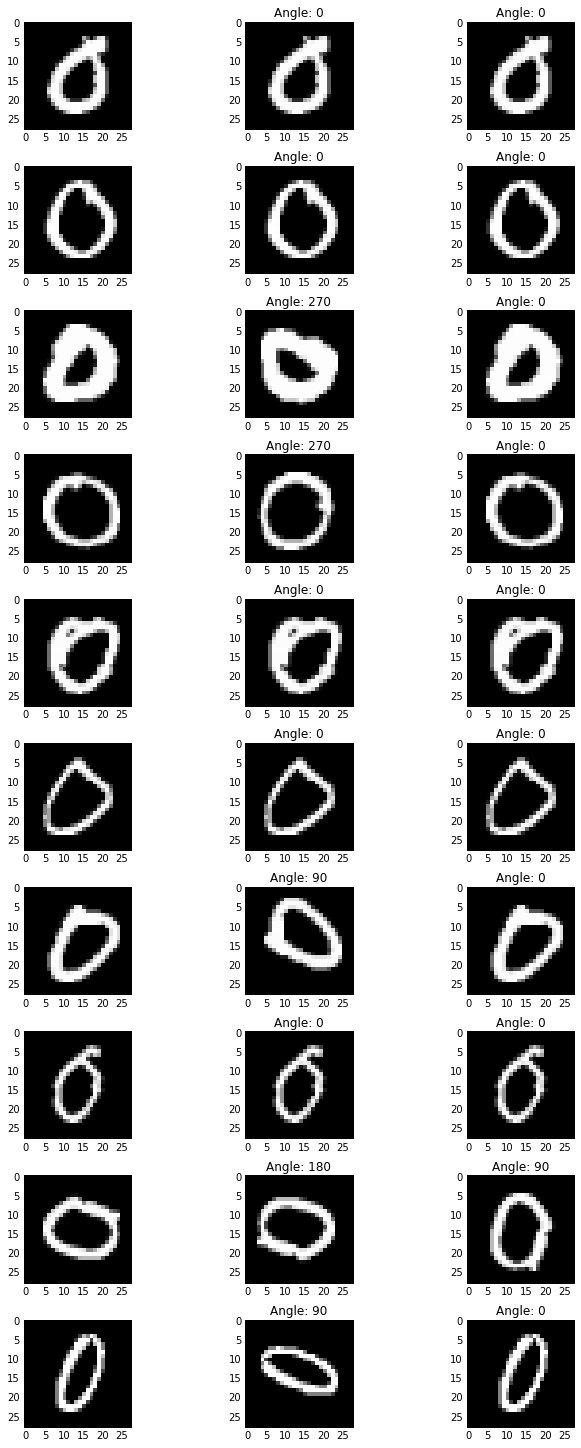

In [62]:
plot_examples(X_test, y_test, y_test_angle, y_test_predicted_angles, number=0, angle=None, only_errors=False, num_test_images=10)

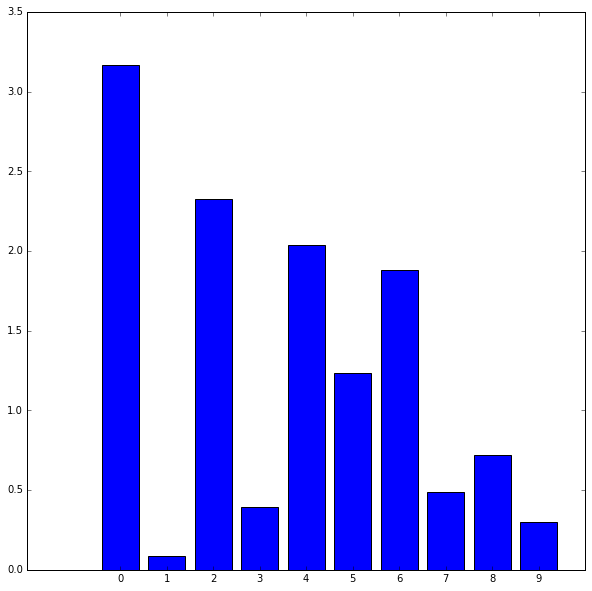

In [64]:
plot_error_hist(y_test, y_test_angle, y_predicted_angles)